<a href="https://colab.research.google.com/github/XiaoLiang28/Xiao/blob/main/Fall_23_PS0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This semester I want to explore the relationship between segregation and students' academic performance in public schools in New Jersey.

Research has found that students' test scores increased across all racial/ethnic groups during the last few decades, and the increases among Black and Hispanic students are larger than among White students. However, for students from different socioeconomic backgrounds, equitable access to educational opportunities has not improved along with overall educational outcomes (Matheny et al., 2023)
.

Therefore, I want to explore the relationship between segregation and students' academic performance in New Jersey by using data from the Education Department of NJ to understand if srgregation lead to worse students' academic performance.

Matheny, K. T., Thompson, M. E., Townley-Flores, C., & reardon, sean f. (2023). Uneven Progress: Recent Trends in Academic Performance Among U.S. School Districts. American Educational Research Journal, 60(3), 447–485. https://doi.org/10.3102/00028312221134769

Data from https://www.nj.gov/education/doedata/enr/ (2020-2021 Enrollment District Reported Data).

# Set Up

In [ ]:
#---------------------------SETUP----------------------------------
#get useful libraries
import time, os, sys, re #basics
import zipfile, json, datetime, string   #string for annotating points in scatter
import numpy as np #basic math
from statistics import * #stats

import matplotlib.pyplot as plt #import pylab as plt #apparently discouraged now:
 #https://stackoverflow.com/questions/11469336/what-is-the-difference-between-pylab-and-pyplot
 #https://www.tutorialspoint.com/matplotlib/matplotlib_pylab_module.htm

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
#s4 = Styler(df4, uuid_len=0, cell_ids=False)

import urllib  #weird, guess need to have os and pandas imported for this to work  %TODO/LATER ditch it, its weird anyway, just use wget/curl

from google.colab import files

#import webbrowser

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

#many tricks how to extend notebook functionality
#https://coderzcolumn.com/tutorials/python/list-of-useful-magic-commands-in-jupyter-notebook-lab
#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#MAGICS and THEMES/STYLES: important! does affect not just shading/colors, but also fonts, spacing, etc
#(even if you only select default (v not selecting anything) [but does seem to work better if you do make explicit sleections])

###magics: https://ipython.readthedocs.io/en/stable/interactive/magics.html
#most essential setup for vis: it does affect vis! careful!! stick with inline, maybe notebook; others mostly for non-notebook, eg spyder environ
#https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html recomends *inline*!
#show current one:
#%matplotlib
#%matplotlib --list
#interactive plots:
#%matplotlib notebook
#static images of your plot:
%matplotlib inline
#may play with this one and other magics (btw default is probably agg)
#%matplotlib nbagg

###themes/styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
#https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
#https://matplotlib.org/stable/tutorials/introductory/customizing.html
#here more about art and style than under the hood functionality as with magics, explore and experiment
#many may find 'default' or seaborn ones more pleasing; my fav 'classic' is back from 90s ;)
#plt.style.available #list available styles :) may install more
#plt.style.use('default') # more delicate subtle than classic
plt.style.use('classic')  #  'seaborn-whitegrid' 'seaborn-white' 'seaborn-poster'
# btw: magics v theme/style sequence matters, eg if i specify classic style before inline magic, i wouldnt get grey bounding box im getting

# Dataset Import and Management

In [ ]:
hd=pd.read_csv("https://github.com/XiaoLiang28/Xiao/raw/main/enrollment_2021.csv")

In [ ]:
hd

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,2020-2021 Enrollment Data - District Counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,...,Tenth Grade,Eleventh Grade,Twelfth Grade,Ungraded,%Free Lunch,%Reduced Lunch,%English Learners,%Migrant,%Military,%Homeless
2,01,Atlantic,0010,Absecon Public Schools District,887,447,50.4,133,15,208,...,0,0,0,25,40.8,5.9,8.7,0,0.8,0.2
3,01,Atlantic,0110,Atlantic City School District,6450,265,4.1,2147,33.3,2847,...,462,405,369,286,81.5,3.6,16.1,0,0,2.2
4,01,Atlantic,0120,Atlantic County Vocational School District,1713,516,30.1,296,17.3,721,...,399,355,362,160,48.6,9.6,0,0,2.5,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,80,Charters,8050,Unity Charter School,245,123,50.2,40,16.3,28,...,0,0,0,0,9.8,1.6,1.2,0,0,0
669,80,Charters,8060,University Academy Charter High School,439,18,4.1,240,54.7,142,...,118,105,100,0,53.3,9.8,0,0,0,0
670,80,Charters,8065,University Heights Charter School,858,0,0,724,84.4,133,...,0,0,0,0,73.1,13.9,6.4,0,0,0
671,80,Charters,8140,The Village Charter School,363,4,1.1,345,95,14,...,0,0,0,0,64.5,5.5,0,0,0,0


In [ ]:
hd.drop([0, 672])

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,...,Tenth Grade,Eleventh Grade,Twelfth Grade,Ungraded,%Free Lunch,%Reduced Lunch,%English Learners,%Migrant,%Military,%Homeless
2,01,Atlantic,0010,Absecon Public Schools District,887,447,50.4,133,15,208,...,0,0,0,25,40.8,5.9,8.7,0,0.8,0.2
3,01,Atlantic,0110,Atlantic City School District,6450,265,4.1,2147,33.3,2847,...,462,405,369,286,81.5,3.6,16.1,0,0,2.2
4,01,Atlantic,0120,Atlantic County Vocational School District,1713,516,30.1,296,17.3,721,...,399,355,362,160,48.6,9.6,0,0,2.5,0.6
5,01,Atlantic,0125,Atlantic County Special Services School District,306,95,31,82,26.8,108,...,3,5,13,244,39.5,5.9,0.3,0,0.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,80,Charters,8010,Union County Teams Charter School-High School/...,400,1,0.3,242,60.5,153,...,33,34,39,0,61.3,10,4,0,0,4.8
668,80,Charters,8050,Unity Charter School,245,123,50.2,40,16.3,28,...,0,0,0,0,9.8,1.6,1.2,0,0,0
669,80,Charters,8060,University Academy Charter High School,439,18,4.1,240,54.7,142,...,118,105,100,0,53.3,9.8,0,0,0,0
670,80,Charters,8065,University Heights Charter School,858,0,0,724,84.4,133,...,0,0,0,0,73.1,13.9,6.4,0,0,0


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
hd

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,2020-2021 Enrollment Data - District Counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,%Two or More Races,Pre-K Halfday,Pre-K FullDay,Kindergarten Halfday,Kindergarten Fullday,First Grade,Second Grade,Third Grade,Fourth Grade,Fifth Grade,Sixth Grade,Seventh Grade,Eight Grade,Ninth Grade,Tenth Grade,Eleventh Grade,Twelfth Grade,Ungraded,%Free Lunch,%Reduced Lunch,%English Learners,%Migrant,%Military,%Homeless
2,01,Atlantic,0010,Absecon Public Schools District,887,447,50.4,133,15,208,23.4,57,6.4,0,0,0,0,42,4.7,0,48,0,83,94,76,107,88,84,94,94,94,0,0,0,0,25,40.8,5.9,8.7,0,0.8,0.2
3,01,Atlantic,0110,Atlantic City School District,6450,265,4.1,2147,33.3,2847,44.1,1046,16.2,1,0,42,0.7,102,1.6,0,340,0,379,482,429,472,440,457,473,487,473,496,462,405,369,286,81.5,3.6,16.1,0,0,2.2
4,01,Atlantic,0120,Atlantic County Vocational School District,1713,516,30.1,296,17.3,721,42.1,102,6,5,0.3,9,0.5,64,3.7,0,0,0,0,0,0,0,0,0,0,0,0,437,399,355,362,160,48.6,9.6,0,0,2.5,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,80,Charters,8050,Unity Charter School,245,123,50.2,40,16.3,28,11.4,37,15.1,0,0,0,0,17,6.9,0,0,0,28,25,29,25,25,28,30,23,32,0,0,0,0,0,9.8,1.6,1.2,0,0,0
669,80,Charters,8060,University Academy Charter High School,439,18,4.1,240,54.7,142,32.3,39,8.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,118,105,100,0,53.3,9.8,0,0,0,0
670,80,Charters,8065,University Heights Charter School,858,0,0,724,84.4,133,15.5,1,0.1,0,0,0,0,0,0,0,119,0,73,82,89,115,106,66,76,63,69,0,0,0,0,0,73.1,13.9,6.4,0,0,0
671,80,Charters,8140,The Village Charter School,363,4,1.1,345,95,14,3.9,0,0,0,0,0,0,0,0,0,0,0,41,40,40,39,41,43,39,41,39,0,0,0,0,0,64.5,5.5,0,0,0,0


In [ ]:
hd.drop([0, 672])

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,%Two or More Races,Pre-K Halfday,Pre-K FullDay,Kindergarten Halfday,Kindergarten Fullday,First Grade,Second Grade,Third Grade,Fourth Grade,Fifth Grade,Sixth Grade,Seventh Grade,Eight Grade,Ninth Grade,Tenth Grade,Eleventh Grade,Twelfth Grade,Ungraded,%Free Lunch,%Reduced Lunch,%English Learners,%Migrant,%Military,%Homeless
2,01,Atlantic,0010,Absecon Public Schools District,887,447,50.4,133,15,208,23.4,57,6.4,0,0,0,0,42,4.7,0,48,0,83,94,76,107,88,84,94,94,94,0,0,0,0,25,40.8,5.9,8.7,0,0.8,0.2
3,01,Atlantic,0110,Atlantic City School District,6450,265,4.1,2147,33.3,2847,44.1,1046,16.2,1,0,42,0.7,102,1.6,0,340,0,379,482,429,472,440,457,473,487,473,496,462,405,369,286,81.5,3.6,16.1,0,0,2.2
4,01,Atlantic,0120,Atlantic County Vocational School District,1713,516,30.1,296,17.3,721,42.1,102,6,5,0.3,9,0.5,64,3.7,0,0,0,0,0,0,0,0,0,0,0,0,437,399,355,362,160,48.6,9.6,0,0,2.5,0.6
5,01,Atlantic,0125,Atlantic County Special Services School District,306,95,31,82,26.8,108,35.3,11,3.6,1,0.3,5,1.6,4,1.3,0,4,0,0,0,8,4,3,6,3,8,4,1,3,5,13,244,39.5,5.9,0.3,0,0.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,80,Charters,8010,Union County Teams Charter School-High School/...,400,1,0.3,242,60.5,153,38.3,4,1,0,0,0,0,0,0,0,0,0,16,18,20,20,22,24,44,35,39,56,33,34,39,0,61.3,10,4,0,0,4.8
668,80,Charters,8050,Unity Charter School,245,123,50.2,40,16.3,28,11.4,37,15.1,0,0,0,0,17,6.9,0,0,0,28,25,29,25,25,28,30,23,32,0,0,0,0,0,9.8,1.6,1.2,0,0,0
669,80,Charters,8060,University Academy Charter High School,439,18,4.1,240,54.7,142,32.3,39,8.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,118,105,100,0,53.3,9.8,0,0,0,0
670,80,Charters,8065,University Heights Charter School,858,0,0,724,84.4,133,15.5,1,0.1,0,0,0,0,0,0,0,119,0,73,82,89,115,106,66,76,63,69,0,0,0,0,0,73.1,13.9,6.4,0,0,0


In [ ]:
hd.drop(['Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41'],axis=1, inplace=True)

In [ ]:
hd

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2020-2021 Enrollment Data - District Counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,%Two or More Races
2,01,Atlantic,0010,Absecon Public Schools District,887,447,50.4,133,15,208,23.4,57,6.4,0,0,0,0,42,4.7
3,01,Atlantic,0110,Atlantic City School District,6450,265,4.1,2147,33.3,2847,44.1,1046,16.2,1,0,42,0.7,102,1.6
4,01,Atlantic,0120,Atlantic County Vocational School District,1713,516,30.1,296,17.3,721,42.1,102,6,5,0.3,9,0.5,64,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,80,Charters,8050,Unity Charter School,245,123,50.2,40,16.3,28,11.4,37,15.1,0,0,0,0,17,6.9
669,80,Charters,8060,University Academy Charter High School,439,18,4.1,240,54.7,142,32.3,39,8.9,0,0,0,0,0,0
670,80,Charters,8065,University Heights Charter School,858,0,0,724,84.4,133,15.5,1,0.1,0,0,0,0,0,0
671,80,Charters,8140,The Village Charter School,363,4,1.1,345,95,14,3.9,0,0,0,0,0,0,0,0


In [ ]:
hd = hd.rename(columns={'Unnamed: 0': 'County Code', 'Unnamed: 1': 'County Name', 'Unnamed: 2': 'District Code'})

In [ ]:
hd

,County Code,County Name,District Code,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2020-2021 Enrollment Data - District Counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,%Two or More Races
2,01,Atlantic,0010,Absecon Public Schools District,887,447,50.4,133,15,208,23.4,57,6.4,0,0,0,0,42,4.7
3,01,Atlantic,0110,Atlantic City School District,6450,265,4.1,2147,33.3,2847,44.1,1046,16.2,1,0,42,0.7,102,1.6
4,01,Atlantic,0120,Atlantic County Vocational School District,1713,516,30.1,296,17.3,721,42.1,102,6,5,0.3,9,0.5,64,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,80,Charters,8050,Unity Charter School,245,123,50.2,40,16.3,28,11.4,37,15.1,0,0,0,0,17,6.9
669,80,Charters,8060,University Academy Charter High School,439,18,4.1,240,54.7,142,32.3,39,8.9,0,0,0,0,0,0
670,80,Charters,8065,University Heights Charter School,858,0,0,724,84.4,133,15.5,1,0.1,0,0,0,0,0,0
671,80,Charters,8140,The Village Charter School,363,4,1.1,345,95,14,3.9,0,0,0,0,0,0,0,0


In [ ]:
hd = hd.rename(columns={'Unnamed: 3': 'District Name', 'Unnamed: 4': 'Total Enrollment', 'Unnamed: 5': 'White', 'Unnamed: 6': '%White', 'Unnamed: 7': 'Black', 'Unnamed: 8': '%Black', 'Unnamed: 9': 'Hispanic', 'Unnamed: 10': '%Hispanic', 'Unnamed: 11': 'Asian', 'Unnamed: 12': '%Asian', 'Unnamed: 13': 'Native American', 'Unnamed: 14': '%Native American', 'Unnamed: 15': 'Hawaiian Native', 'Unnamed: 16': '%Hawaiian Native', 'Unnamed: 17': 'Two or More Races', 'Unnamed 18': '%Two or More Races'})

In [ ]:
hd

,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,Unnamed: 18
0,2020-2021 Enrollment Data - District Counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,%Two or More Races
2,01,Atlantic,0010,Absecon Public Schools District,887,447,50.4,133,15,208,23.4,57,6.4,0,0,0,0,42,4.7
3,01,Atlantic,0110,Atlantic City School District,6450,265,4.1,2147,33.3,2847,44.1,1046,16.2,1,0,42,0.7,102,1.6
4,01,Atlantic,0120,Atlantic County Vocational School District,1713,516,30.1,296,17.3,721,42.1,102,6,5,0.3,9,0.5,64,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,80,Charters,8050,Unity Charter School,245,123,50.2,40,16.3,28,11.4,37,15.1,0,0,0,0,17,6.9
669,80,Charters,8060,University Academy Charter High School,439,18,4.1,240,54.7,142,32.3,39,8.9,0,0,0,0,0,0
670,80,Charters,8065,University Heights Charter School,858,0,0,724,84.4,133,15.5,1,0.1,0,0,0,0,0,0
671,80,Charters,8140,The Village Charter School,363,4,1.1,345,95,14,3.9,0,0,0,0,0,0,0,0


In [ ]:
hd.drop([0, 1, 672])

In [ ]:
hd.head(2)
hd.tail(2)

,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,Unnamed: 18
0,2020-2021 Enrollment Data - District Counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,%Two or More Races


,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,Unnamed: 18
671,80,Charters,8140,The Village Charter School,363,4,1.1,345,95,14,3.9,0,0,0,0,0,0,0,0
672,End of worksheet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Question: I dropped row0 and row672 many times, but I don't know why I cannot drop them.

aok: good, good to ask questions! because you didnt reassign; try:

hd = hd.drop([0, 1, 672])

or

hd.drop([0, 1, 672],inplace=True)

In [ ]:
#i'd just drop on condition--more intuitive and safer than on index:
hd=hd[hd['County Code']!='End of worksheet']
hd.tail(2)
#https://www.statology.org/pandas-drop-rows-with-value/

,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,Unnamed: 18
670,80,Charters,8065,University Heights Charter School,858,0,0,724,84.4,133,15.5,1,0.1,0,0,0,0,0,0
671,80,Charters,8140,The Village Charter School,363,4,1.1,345,95,14,3.9,0,0,0,0,0,0,0,0


In [ ]:
hd["County Name"][0:3]

0            NaN
1    County Name
2       Atlantic
Name: County Name, dtype: object

In [ ]:
hd[["%White","%Black"]][0:3]

,%White,%Black
0,NaN,NaN
1,%White,%Black
2,50.4,15


In [ ]:
hd.sample(frac=0.5, replace=False, random_state=1)

,County Code,County Name,District Code,District Name,Total Enrollment,White,%White,Black,%Black,Hispanic,%Hispanic,Asian,%Asian,Native American,%Native American,Hawaiian Native,%Hawaiian Native,Two or More Races,Unnamed: 18
404,27,Morris,2460,Kinnelon School District,1651.5,1320,79.9,20,1.2,125.5,7.6,121,7.3,6,0.4,4,0.2,55,3.3
611,80,Charters,6082,Beloved Community Charter School,1311,251,19.1,375,28.6,381,29.1,257,19.6,8,0.6,5,0.4,34,2.6
375,25,Monmouth,3830,Oceanport School District,537,459,85.5,6,1.1,52,9.7,2,0.4,0,0,0,0,18,3.4
496,35,Somerset,0490,Bound Brook School District,1930.5,220,11.4,192.5,10,1452.5,75.2,20,1,2.5,0.1,11,0.6,32,1.7
57,03,Bergen,2620,Leonia Public School District,2081.5,541.5,26,78,3.7,480,23.1,868,41.7,6,0.3,5,0.2,103,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,05,Burlington,1520,Florence Township School District,1465,810,55.3,313,21.4,148,10.1,164,11.2,7,0.5,4,0.3,19,1.3
557,39,Union,5245,Union County Educational Services Commission,292,47,16.1,107,36.6,124,42.5,14,4.8,0,0,0,0,0,0
668,80,Charters,8050,Unity Charter School,245,123,50.2,40,16.3,28,11.4,37,15.1,0,0,0,0,17,6.9
378,25,Monmouth,4520,Roosevelt Borough Public School District,72,54,75,3,4.2,12,16.7,0,0,0,0,0,0,3,4.2


aok: when you produce descriptive stats/graphs below--interpret them; and try to make sure axes labels are readable

we will cover graphs later, for now can stick with tables and code we cover in class

<Axes: >

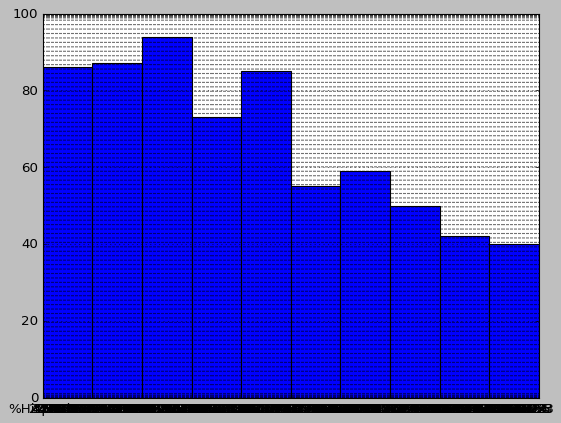

In [ ]:
hd["%Hispanic"].hist()

<Axes: xlabel='%White', ylabel='%Asian'>

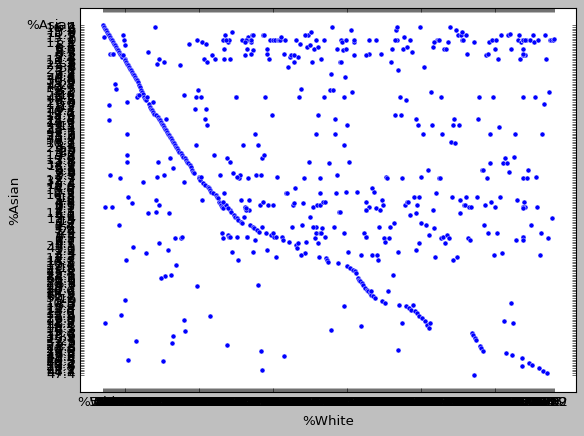

In [ ]:
sns.scatterplot(data=hd,x='%White',y='%Asian')